- [ ] Try to overfit earlier
    * Try adding more layers

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from scipy import signal
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

%matplotlib inline

## Load data

In [2]:
data_path = "Data/GeneratedData/combined_data/"
base_path = os.getcwd()

# REST
# IDD = np.load(os.path.join(data_path, "IDD_rest.npy"))
# TDC = np.load(os.path.join(data_path, "TDC_rest.npy"))

# MUSIC
# IDD = np.load(os.path.join(data_path, "IDD_music.npy"))
# TDC = np.load(os.path.join(data_path, "TDC_music.npy"))

X_scalogram = np.load("Data/GeneratedData/X_scalogram_music.npy")
Y = [0]*(len(X_scalogram)//2) + [1]*(len(X_scalogram)//2)
Y = np.asarray(Y)

In [3]:
print(X_scalogram.shape)
print(Y.shape)

(8470, 448, 128)
(8470,)


## Create Spectrograms

In [4]:
# Modified scalogram function from Fusion notebook
def scalogram(x, Hz, hz, num_secs, w = 5.):
    ''' x = time series
        Hz = sampling rate in Hz of the input signal
        hz = desired sampling rate (by downsampling)
        start_sec = starting second in x
        num_secs = total number of seconds of our clip
        w = width parameter
        log =raw_seiz if true take log of spectrum values
    '''
    
    downsample = int(round(Hz / hz))
    X = x[0: num_secs * Hz : downsample]


    t, dt = np.linspace(0, num_secs, hz * num_secs, retstep = True)
    fs = 1 / dt

    freq = np.linspace(1, fs / 2, int(hz / 2))
    widths = w * fs / (2 * np.pi * freq)

    cwtm = signal.cwt(X,
                      signal.morlet2,
                      widths,
                      w = w)
    
    return cwtm.real.astype("float64")

In [5]:
def generate_scalogram(data, Hz, hz, num_secs, w = 5.):
    scalogram_data = np.zeros((data.shape[0], data.shape[1] * (hz // 2), hz * num_secs), dtype="float64")
    for sample_index in tqdm(range(data.shape[0])):
        for channel_index in range(0, data.shape[1]):
            scalogram_data[sample_index][channel_index * (hz//2): channel_index * (hz//2) + hz//2] = \
            scalogram(data[sample_index][channel_index], 128, 64, 2)
    return scalogram_data

In [6]:
# X_scalogram = generate_scalogram(X, 128, 64, 2)

In [7]:
X_scalogram.shape

(8470, 448, 128)

In [8]:
def plot_scalograms(data, sample_index, N=128, hz=64, T=2, ts=0, w=4.):
    """
    :param N: signal sampling rate
    :param hz: downsampled sampling rate
    :param T: seconds
    :param ts: starting second
    :param w: 
    """

    t, dt = np.linspace(ts, ts + T, hz * T, retstep = True)
    fs = 1 / dt

    freq = np.linspace(1, (14 * (fs / 2)), (14 * int(hz / 2)))
    
    print("Y label:", Y[sample_index])
    
    plt.rcParams['figure.figsize'] = 14, 30
    im = plt.pcolormesh(t, freq, np.abs(data[sample_index]), cmap = 'jet') # 'viridis'
    plt.show()


Y label: 0


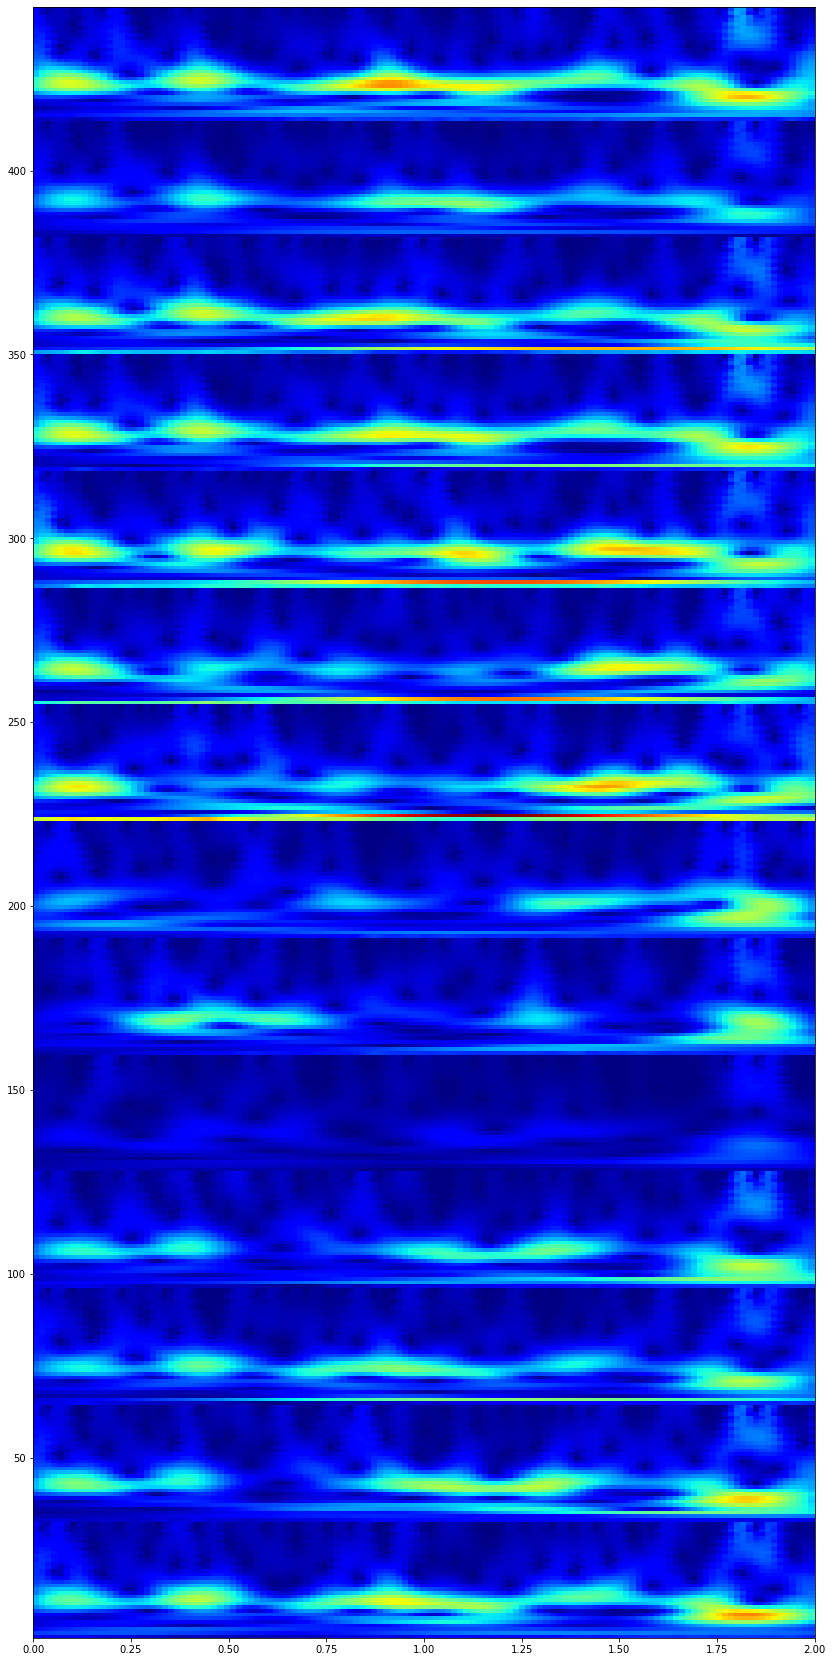

In [9]:
plot_scalograms(X_scalogram, 2000)

In [10]:
# reshape data
X_scalogram_shaped = X_scalogram.reshape(X_scalogram.shape[0], X_scalogram.shape[1] * X_scalogram.shape[2])
X_scalogram_shaped.shape

(8470, 57344)

## Test-Train split

In [11]:
# X_train, X_val, y_train, y_val = train_test_split(X_scalogram_shaped, Y, test_size=0.2, stratify=Y, random_state=42)

In [12]:
# 10/4 split
X_train = np.concatenate((X_scalogram_shaped[:3025], X_scalogram_shaped[4235:7260]))
y_train = np.concatenate((Y[:3025], Y[4235:7260]))

X_val = np.concatenate((X_scalogram_shaped[3025:4235], X_scalogram_shaped[7260:]))
y_val = np.concatenate((Y[3025:4235], Y[7260:]))

# shuffle data
X_train, y_train = shuffle(X_train, y_train, random_state=42)
X_val, y_val = shuffle(X_val, y_val, random_state=42)

In [13]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
input_shape = X_train.shape[1]
print("input_shape:", input_shape)

X_train shape: (6050, 57344)
y_train shape: (6050,)
X_val shape: (2420, 57344)
y_val shape: (2420,)
input_shape: 57344


## Model

### Sklearn

In [14]:
# clf = LogisticRegression(solver='saga',
#                          multi_class='ovr', 
#                          verbose=1).fit(X_train, y_train)

In [15]:
# score = clf.score(X_val, y_val)  
# print(score)

In [16]:
# from sklearn import metrics
# predictions = clf.predict(X_val)
# cm = metrics.confusion_matrix(y_val, predictions)  
# print(cm)

In [17]:
# nclasses = 1

# scale = np.max(np.abs(clf.coef_))

# p = plt.figure(figsize=(25, 30));

# p = plt.imshow(clf.coef_[0].reshape(448, 128),
#               cmap=plt.cm.RdBu, vmin=-scale, vmax=scale);
# p = plt.axis('off')

### Keras

In [18]:
model1 = keras.Sequential([
    keras.layers.Dense(1, input_dim=input_shape, activation=tf.nn.sigmoid)
])

model1.compile(
  optimizer='adam',
  loss='binary_crossentropy',
  metrics=['accuracy'],
)
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 57345     
Total params: 57,345
Trainable params: 57,345
Non-trainable params: 0
_________________________________________________________________


In [19]:
history = model1.fit(X_train, 
                    y_train, 
                    epochs=10, 
                    batch_size=256,
                    validation_data=(X_val, y_val), 
                    verbose=1)

Train on 6050 samples, validate on 2420 samples
Epoch 1/10
6050/6050 [==============================] - 14s 2ms/sample - loss: 12.8752 - accuracy: 0.4909 - val_loss: 9.5865 - val_accuracy: 0.5041
Epoch 2/10
6050/6050 [==============================] - 14s 2ms/sample - loss: 9.2842 - accuracy: 0.5486 - val_loss: 8.4436 - val_accuracy: 0.5070
Epoch 3/10
6050/6050 [==============================] - 5s 888us/sample - loss: 8.6687 - accuracy: 0.5544 - val_loss: 9.8421 - val_accuracy: 0.5083
Epoch 4/10
6050/6050 [==============================] - 3s 413us/sample - loss: 8.6659 - accuracy: 0.5570 - val_loss: 8.9383 - val_accuracy: 0.5116
Epoch 5/10
6050/6050 [==============================] - 2s 379us/sample - loss: 8.2582 - accuracy: 0.5651 - val_loss: 9.7320 - val_accuracy: 0.5070
Epoch 6/10
6050/6050 [==============================] - 9s 1ms/sample - loss: 8.9839 - accuracy: 0.5577 - val_loss: 9.5771 - val_accuracy: 0.5116
Epoch 7/10
6050/6050 [==============================] - 16s 3ms/sam

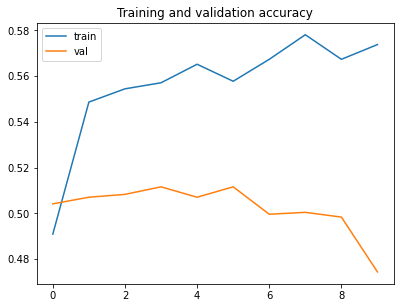

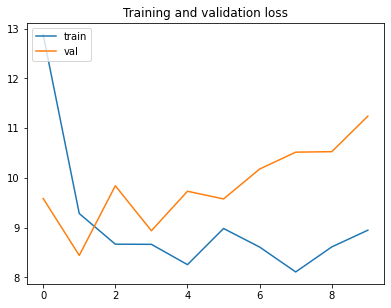

In [20]:
# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))
plt.figure(figsize=(6.4,4.8))
# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')
plt.legend(['train', 'val'], loc='upper left')

plt.figure(figsize=(6.4,4.8))

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')
plt.legend(['train', 'val'], loc='upper left')

In [21]:
model2 = keras.Sequential([
    keras.layers.Dense(8, input_dim=input_shape, activation=tf.nn.relu), 
    keras.layers.Dense(4, activation=tf.nn.relu), 
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

model2.compile(
  optimizer='adam',
  loss='binary_crossentropy',
  metrics=['accuracy'],
)
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8)                 458760    
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5         
Total params: 458,801
Trainable params: 458,801
Non-trainable params: 0
_________________________________________________________________


In [22]:
history = model2.fit(X_train, 
                    y_train, 
                    epochs=20, 
                    batch_size=256,
                    validation_data=(X_val, y_val), 
                    verbose=1)

Train on 6050 samples, validate on 2420 samples
Epoch 1/20
6050/6050 [==============================] - 5s 833us/sample - loss: 7.5636 - accuracy: 0.6795 - val_loss: 6.0222 - val_accuracy: 0.7116
Epoch 2/20
6050/6050 [==============================] - 3s 431us/sample - loss: 2.6087 - accuracy: 0.8597 - val_loss: 4.7209 - val_accuracy: 0.7624
Epoch 3/20
6050/6050 [==============================] - 3s 440us/sample - loss: 1.3281 - accuracy: 0.9076 - val_loss: 4.4463 - val_accuracy: 0.7843
Epoch 4/20
6050/6050 [==============================] - 6s 1ms/sample - loss: 0.7172 - accuracy: 0.9360 - val_loss: 4.3259 - val_accuracy: 0.7946
Epoch 5/20
6050/6050 [==============================] - 3s 441us/sample - loss: 0.5182 - accuracy: 0.9484 - val_loss: 3.9474 - val_accuracy: 0.7988
Epoch 6/20
6050/6050 [==============================] - 3s 452us/sample - loss: 0.3296 - accuracy: 0.9549 - val_loss: 4.2113 - val_accuracy: 0.7992
Epoch 7/20
6050/6050 [==============================] - 3s 434us/s

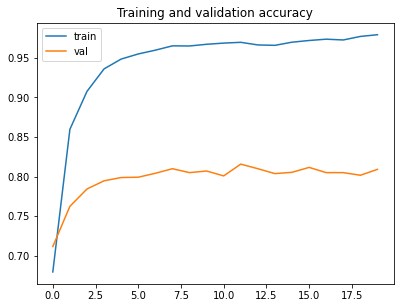

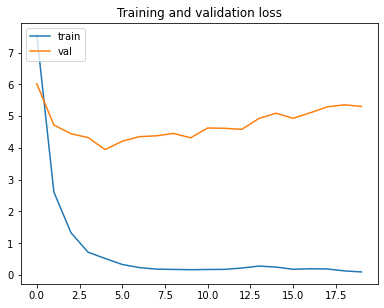

In [23]:
# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))
plt.figure(figsize=(6.4,4.8))
# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')
plt.legend(['train', 'val'], loc='upper left')

plt.figure(figsize=(6.4,4.8))

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')
plt.legend(['train', 'val'], loc='upper left')